# Project Purpose

Create an algorithm that takes an HTML page as input and infers if the page contains the information about cancer tumor board or not.

Tumor Board is a consilium of doctors (usually from diferent disciplines) discussing cancer cases in their departments.

Some questions to ask along the process and at the end of the project:
- How to handle this amount of data?
- How to do feature engineering?
- How to decide which models to try?
- How to perform validation of the model?
- What metrics to measure?
- How will the model to perform on test data?
- How fast will the algorithm perform and how to improve its performance if given more time?
- How can I improve the algorithm if given more data?
- What potential issues to expect with the algorithm?


# Introduction

As a first step in solving this problem, we will load the provided CSV files using the Pandas library. The training CSV file contains 100 rows, with three columns: URL, doc_id, and a label. The test CSV file has 48 rows with two columns: URL and doc_id. The goal is to train a machine learning model that can predict a label for the documents provided in the test CSV based on the data that is available in the training CSV.

In [48]:
import pandas as pd

In [49]:
github_link_train = "https://github.com/mikele5895/nlp-tumor-board-keywords-detection/raw/refs/heads/main/train.csv"
train_csv = pd.read_csv(github_link_train)
print("Training set shape", train_csv.shape)
train_csv.head()

Training set shape (100, 3)


,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3


In [50]:
github_link_test = "https://github.com/mikele5895/nlp-tumor-board-keywords-detection/raw/refs/heads/main/test.csv"
test_csv = pd.read_csv(github_link_test)
print("Test set shape", test_csv.shape)
test_csv.head()

Test set shape (48, 2)


,url,doc_id
0,http://chirurgie-goettingen.de/medizinische-ve...,0
1,http://evkb.de/kliniken-zentren/chirurgie/allg...,2
2,http://krebszentrum.kreiskliniken-reutlingen.d...,7
3,http://marienhospital-buer.de/mhb-av-chirurgie...,15
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16


In [51]:
github_link_keywords = "https://github.com/mikele5895/nlp-tumor-board-keywords-detection/raw/refs/heads/main/keyword2tumor_type.csv"
tumor_keywords = pd.read_csv(github_link_keywords)
print("Tumor keywords set shape", tumor_keywords.shape)
tumor_keywords.head()

Tumor keywords set shape (126, 2)


,keyword,tumor_type
0,senologische,Brust
1,brustzentrum,Brust
2,breast,Brust
3,thorax,Brust
4,thorakale,Brust


We have 100 documents in the training set, and 48 in the test set. We have 32 documents that mention no tumor board (label = 1), 59 documents where a tumor board is mentioned, but we are not certain if it is the main focus of the page (label = 2), and 9 documents for which we are certain that they are dedicated to tumor boards.

In [52]:
train_csv.groupby(by="label").size()

,0
label,
1,32
2,59
3,9


# Load the data

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
def read_html(doc_id: int) -> str:
        with open(file=f"htmls/{doc_id}.html",
                  mode="r",
                  encoding="latin1") as f:
            html = f.read()
        return html

train_csv["html"] = train_csv["doc_id"].apply(read_html)

In [55]:
train_csv.sample(n=5, random_state=42)

,url,doc_id,label,html
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_..."
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or..."
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<..."
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me..."
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T..."


In [56]:
import warnings

from bs4 import BeautifulSoup

warnings.filterwarnings(action="ignore")


def extract_html_text(html):
    bs = BeautifulSoup(markup=html, features="lxml")
    for script in bs(name=["script", "style"]):
        script.decompose()
    return bs.get_text(separator=" ")

train_csv["html_text"] = train_csv["html"].apply(extract_html_text)

In [57]:
train_csv.sample(n=5, random_state=42)

,url,doc_id,label,html,html_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n \n \n \n \n Prostata-Karzinom-Zentrum - Sch...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n \n \n \n Darmzentrum Rheinpfalz » Zentren A...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...


So far we are making some progress, but we immediately observe an issue, and that is the large number of new line symbols \n at the beginning of each document. Ideally, we would want to provide clear text, with no special characters and in a proper, human-readable format.

In [58]:
from gensim.parsing import preprocessing


def preprocess_html_text(html_text: str) -> str:
    preprocessed_text = preprocessing.strip_non_alphanum(s=html_text)
    preprocessed_text = preprocessing.strip_multiple_whitespaces(s=preprocessed_text)
    preprocessed_text = preprocessing.strip_punctuation(s=preprocessed_text)
    preprocessed_text = preprocessing.strip_numeric(s=preprocessed_text)

    preprocessed_text = preprocessing.stem_text(text=preprocessed_text)
    preprocessed_text = preprocessing.remove_stopwords(s=preprocessed_text)
    return preprocessed_text


train_csv["preprocessed_html_text"] = train_csv["html_text"].apply(preprocess_html_text)

In [59]:
train_csv.sample(n=5, random_state=42)

,url,doc_id,label,html,html_text,preprocessed_html_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n \n \n \n \n Prostata-Karzinom-Zentrum - Sch...,prostata karzinom zentrum schwarzwald baar kli...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,unser profil gefã ã und thoraxchirurgi kliniku...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,maltes kliniken rhein ruhr darmzentrum duisbur...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n \n \n \n Darmzentrum Rheinpfalz » Zentren A...,darmzentrum rheinpfalz zentren z kliniken und ...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,mund kiefer und plastisch gesichtschirurgi en ...


# EDA

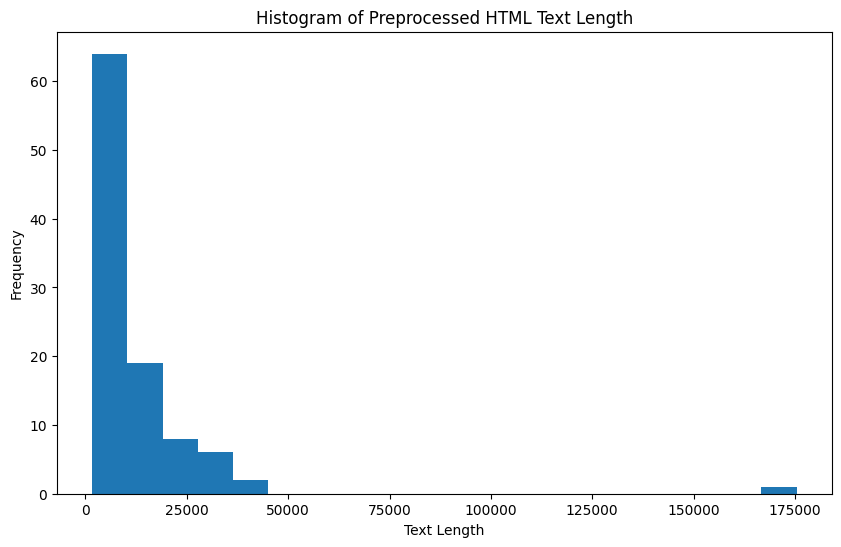

In [64]:
import matplotlib.pyplot as plt
train_csv['text_length'] = train_csv['preprocessed_html_text'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(train_csv['text_length'], bins=20)
plt.title('Histogram of Preprocessed HTML Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

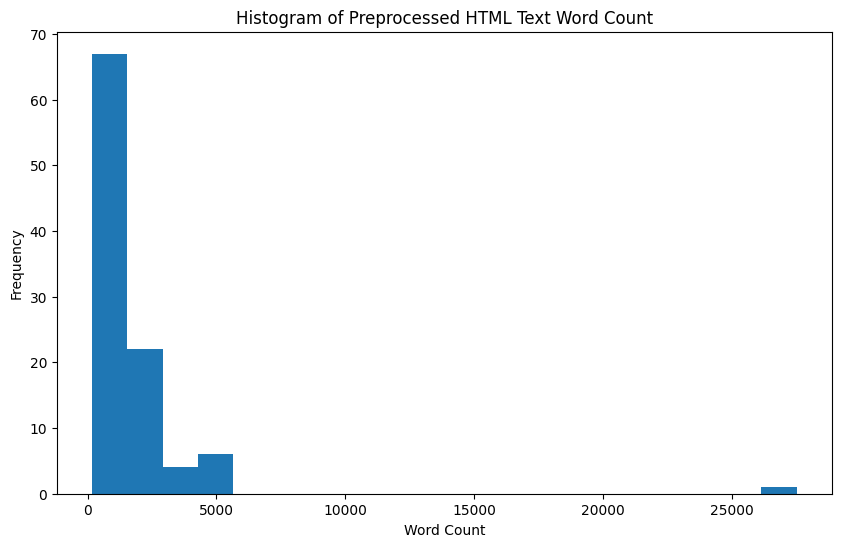

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(train_csv['preprocessed_html_text'].str.split().str.len(), bins=20)
plt.title('Histogram of Preprocessed HTML Text Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

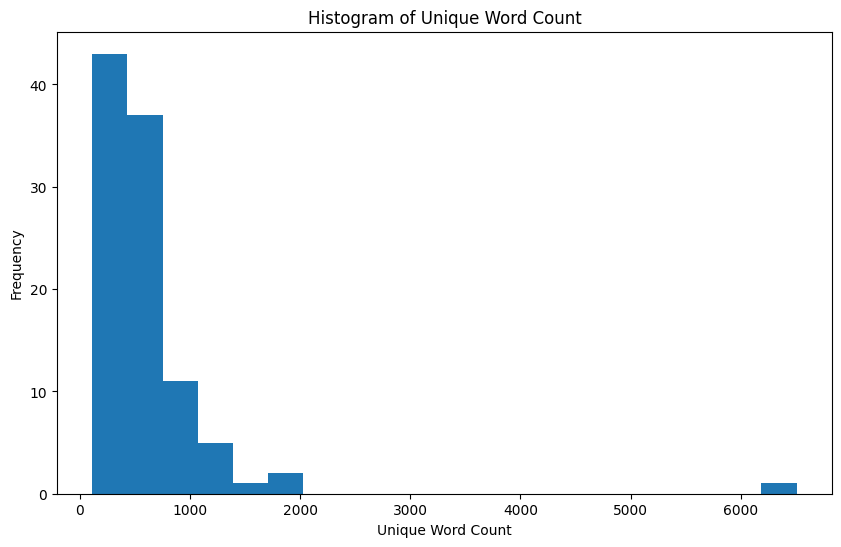

In [67]:
train_csv['unique_word_count'] = train_csv['preprocessed_html_text'].apply(lambda x: len(set(x.split())))

# Plot the histogram of unique word counts
plt.figure(figsize=(10, 6))
plt.hist(train_csv['unique_word_count'], bins=20)
plt.title('Histogram of Unique Word Count')
plt.xlabel('Unique Word Count')
plt.ylabel('Frequency')
plt.show()

# Modeling

To solve our task, we will use a model called the siamese network. Siamese networks are able to address the class imbalance and small data set sizes. They are mostly used in few shots learning tasks, like signature verification systems, face recognition, object detection, etc.

In [68]:
import random
import numpy as np
import tensorflow as tf

# set the random seeds
np.random.seed(42)
tf.random.set_seed(seed=42)

**Data Generators**

In [69]:
class Pair(tf.keras.utils.Sequence):
    def __init__(self, dataframe: pd.DataFrame, labels: pd.Series, n_batch: int, batch_size: int):
        self.dataframe = dataframe
        self.labels = labels
        self.n_batch = n_batch
        self.batch_size = batch_size
        self.all_classes = set(self.labels)
        self.anchor_groups = {}
        for target_class in self.all_classes:
            self.anchor_groups[target_class] = {
                "positive": self.dataframe[self.labels == target_class],
                "negative": self.dataframe[self.labels != target_class]
            }

    def __len__(self):
        return self.n_batch

    def __getitem__(self, item):
        pairs = []

        for i in range(int(self.batch_size / 2)):
            anchor_class = random.randint(1, 3)
            anchor_group = self.anchor_groups[anchor_class]["positive"]
            not_anchor_group = self.anchor_groups[anchor_class]["negative"]

            anchor = anchor_group.sample(n=1).iloc[0]
            positive = anchor_group.sample(n=1).iloc[0]
            negative = not_anchor_group.sample(n=1).iloc[0]

            pairs.append([anchor, positive, 1])
            pairs.append([anchor, negative, 0])

        random.shuffle(x=pairs)
        pairs = np.array(pairs)

        data_pairs = pairs[:, :2]
        targets = pairs[:, 2]

        return data_pairs, tf.convert_to_tensor(targets, dtype=np.float32)

    def get_support_set(self, sample_size: int = 1):
        support_set = {}
        for target_class in self.all_classes:
            support_set[target_class] = self.anchor_groups[target_class]["positive"].sample(n=sample_size)
        return support_set